In [31]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

readRDS = robjects.r['readRDS']

import matplotlib.pyplot as plt

In [104]:
prog = ["SDM", "MAESTRO", "mCSM", "CUPSAT"]
df = []
for i in range(4):
    df.append(readRDS(f"res.ready.{prog[i]}.rds"))
    df[i] = df[i].set_index("key")
    if i == 1 or i == 3:
        df[i]["PRED_DDG"] = -df[i]["PRED_DDG"]
    df[i] = df[i].add_prefix(f"{prog[i][0]}_")
    

In [105]:
result = pd.concat(df, axis=1, join_axes=[df[0].index])
result.head()

S_PDB S_Chain.ID S_POS S_WT S_MUT S_WT_SSE  S_WT_RSA...  \
key                                                                  
1AL0_M_1_A  1AL0          B     1    M     A        b         68.0   
1AL0_M_1_C  1AL0          B     1    M     C        b         68.0   
1AL0_M_1_D  1AL0          B     1    M     D        b         68.0   
1AL0_M_1_E  1AL0          B     1    M     E        b         68.0   
1AL0_M_1_F  1AL0          B     1    M     F        b         68.0   

            S_WT_DEPTH..angstrom.  S_WT_OSP  S_WT_SS     ...      m_WT  m_POS  \
key                                                      ...                    
1AL0_M_1_A                   3.33      0.12        0     ...         M    1.0   
1AL0_M_1_C                   3.33      0.12        0     ...         M    1.0   
1AL0_M_1_D                   3.33      0.12        0     ...         M    1.0   
1AL0_M_1_E                   3.33      0.12        0     ...         M    1.0   
1AL0_M_1_F                   3.33      0.12        0     ...         M    1.0   

           m_MUT  m_PRED_DDG  C_PDB  C_Chain  C_WT  C_POS  C_MUT  C_PRED_DDG  
key                                                                           
1AL0_M_1_A     A      -0.143   1AL0        B     M      1      A        2.36  
1AL0_M_1_C     C      -0.328   1AL0        B     M      1      C        2.97  
1AL0_M_1_D     D       0.276   1AL0        B     M      1      D        3.02  
1AL0_M_1_E     E       0.230   1AL0        B     M      1      E        2.48  
1AL0_M_1_F     F      -0.127   1AL0        B     M      1      F        2.42  

[5 rows x 37 columns]

In [107]:
ddg = result[["S_PRED_DDG", "M_PRED_DDG", "m_PRED_DDG", "C_PRED_DDG"]]
ddg.head()

S_PRED_DDG  M_PRED_DDG  m_PRED_DDG  C_PRED_DDG
key                                                       
1AL0_M_1_A         0.0    0.453225      -0.143        2.36
1AL0_M_1_C         0.0    0.520635      -0.328        2.97
1AL0_M_1_D         0.0    1.035553       0.276        3.02
1AL0_M_1_E         0.0    1.273418       0.230        2.48
1AL0_M_1_F         0.0    0.744781      -0.127        2.42

## Strange zeros for SDM

In [108]:
len(ddg["S_PRED_DDG"].unique()), len(ddg["S_PRED_DDG"])

(745, 43318)

In [109]:
np.array(result[ddg["S_PRED_DDG"] == 0]["S_PDB"].drop_duplicates())

array(['1AL0', '1B8X', '1DEV', '1DZF', '1GKU', '1INP', '1IO1', '1IXM',
       '1LML', '1MUK', '1N0U', '1N7D', '1OW1', '1QSA', '1UOY', '1UX6',
       '1W6K', '1X0T', '1ZHX', '2AYD', '2CI8', '2CIU', '2EGT', '2G3R',
       '2HD9', '2ILR', '2LIS', '2NYK', '2O9U', '2OML', '2QKD', '2VDF',
       '2WB0', '2WP7', '2X3M', '2XJP', '2ZJ8', '3A57', '3BG1', '3BXJ',
       '3DKM', '3EH1', '3MTV', '3O4Z', '3P5J', '3PFG', '3PMQ', '3PR9',
       '3RGZ', '3RKG', '3TCQ', '3TTC', '3UH8', '3VEN', '3WNZ', '3ZHE',
       '3ZZO', '4AEQ', '4AK1', '4APM', '4BKW', '4FO0', '4HCW', '4HS2',
       '4IM0', '4K51', '4O65', '4WFO', '4WHI', '5GV0'], dtype=object)

## PCA with explained ratio

In [110]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler as SS

In [111]:
ddg.describe()

S_PRED_DDG    M_PRED_DDG    m_PRED_DDG    C_PRED_DDG
count  43318.000000  43318.000000  43318.000000  43318.000000
mean      -0.549115     -0.467089     -0.888284     -1.097850
std        1.152919      0.937190      0.934734      2.342107
min       -4.800000     -5.885050     -4.955000    -23.280000
25%       -1.160000     -0.811285     -1.416000     -2.190000
50%       -0.340000     -0.200292     -0.735000     -1.020000
75%        0.200000      0.110153     -0.231000     -0.020000
max        4.690000      2.061828      2.857000     22.860000

In [112]:
model = PCA()
model = Pipeline([("ss", SS()),
                  ("pca", PCA())])
ans = model.fit_transform(ddg)

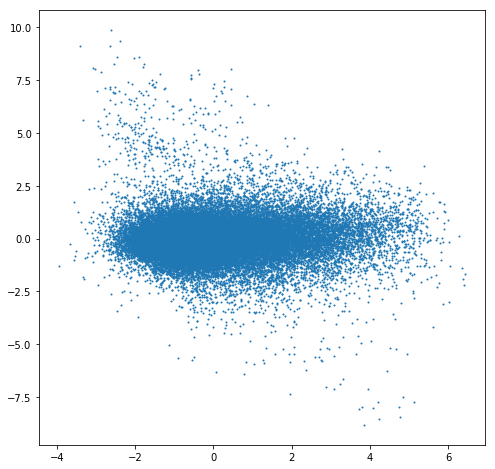

In [115]:
plt.figure(figsize=(8, 8))
plt.scatter(ans[:, 0], ans[:, 1], s=1)

In [116]:
model.steps[1][1].explained_variance_ratio_

array([0.49208979, 0.23181347, 0.14486504, 0.1312317 ])

In [117]:
model.steps["svm"].explained_variance_ratio_, np.cumsum(model.explained_variance_ratio_)

TypeError: list indices must be integers or slices, not str

## TSNE

In [118]:
from sklearn.manifold import TSNE

In [119]:
model = TSNE()
model = Pipeline([("ss", SS()),
                  ("t-SNE", TSNE())])
ans = model.fit_transform(ddg)

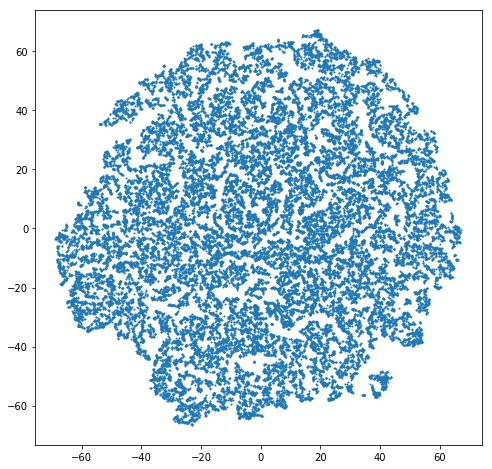

In [120]:
plt.figure(figsize=(8, 8))
plt.scatter(ans[:, 0], ans[:, 1], s=1)

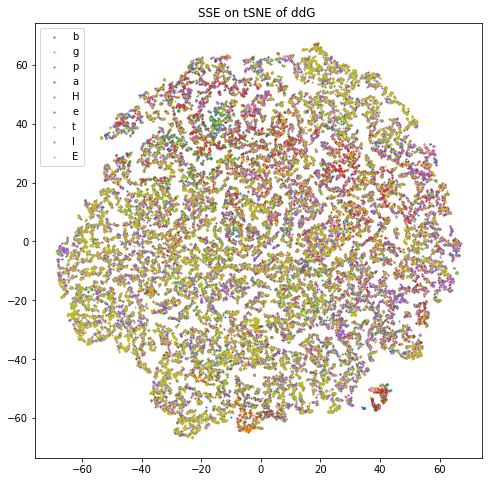

In [121]:
plt.figure(figsize=(8, 8))
plt.title("SSE on tSNE of ddG ")
for i in result.S_WT_SSE.unique():
    tmp = ans[result["S_WT_SSE"] == i]
    plt.scatter(tmp[:, 0], tmp[:, 1], s=1, label=i)
plt.legend()

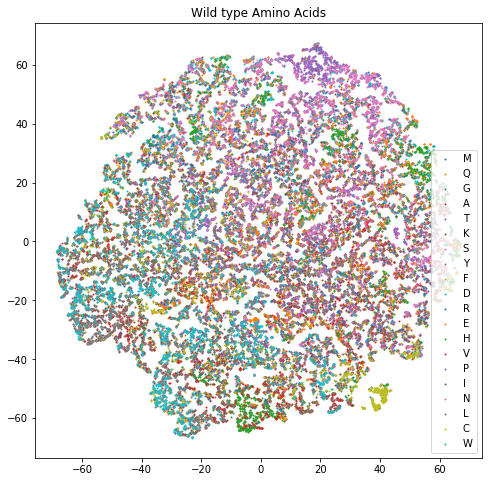

In [122]:
plt.figure(figsize=(8, 8))
plt.title("Wild type Amino Acids")
for i in result.S_WT.unique():
    tmp = ans[result["S_WT"] == i]
    plt.scatter(tmp[:, 0], tmp[:, 1], s=1, label=i)
plt.legend()

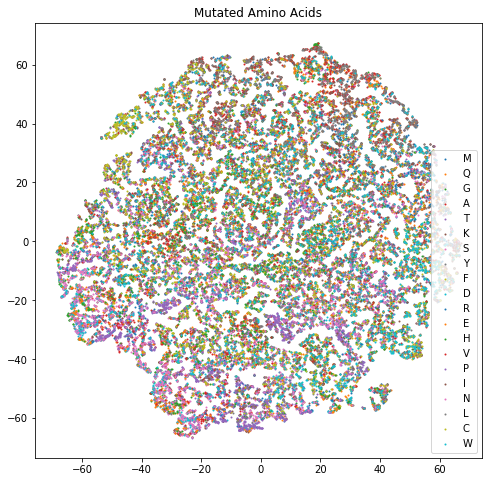

In [123]:
plt.figure(figsize=(8, 8))
plt.title("Mutated Amino Acids")
for i in result.S_WT.unique():
    tmp = ans[result["S_MUT"] == i]
    plt.scatter(tmp[:, 0], tmp[:, 1], s=1, label=i)
plt.legend()

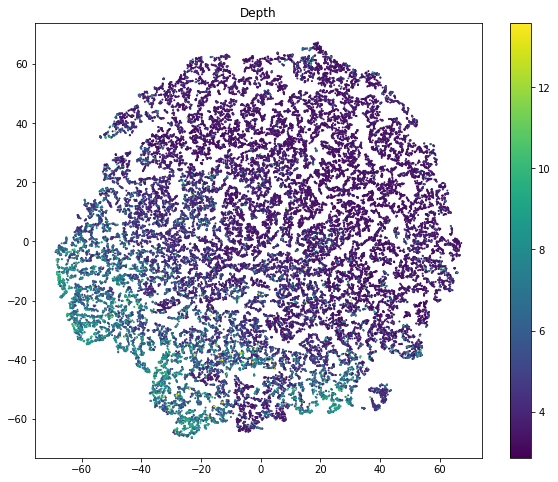

In [124]:
plt.figure(figsize=(10, 8))
plt.title("Depth")
plt.scatter(ans[:, 0], ans[:, 1], s=1, c=result["S_WT_DEPTH..angstrom."])
plt.colorbar()

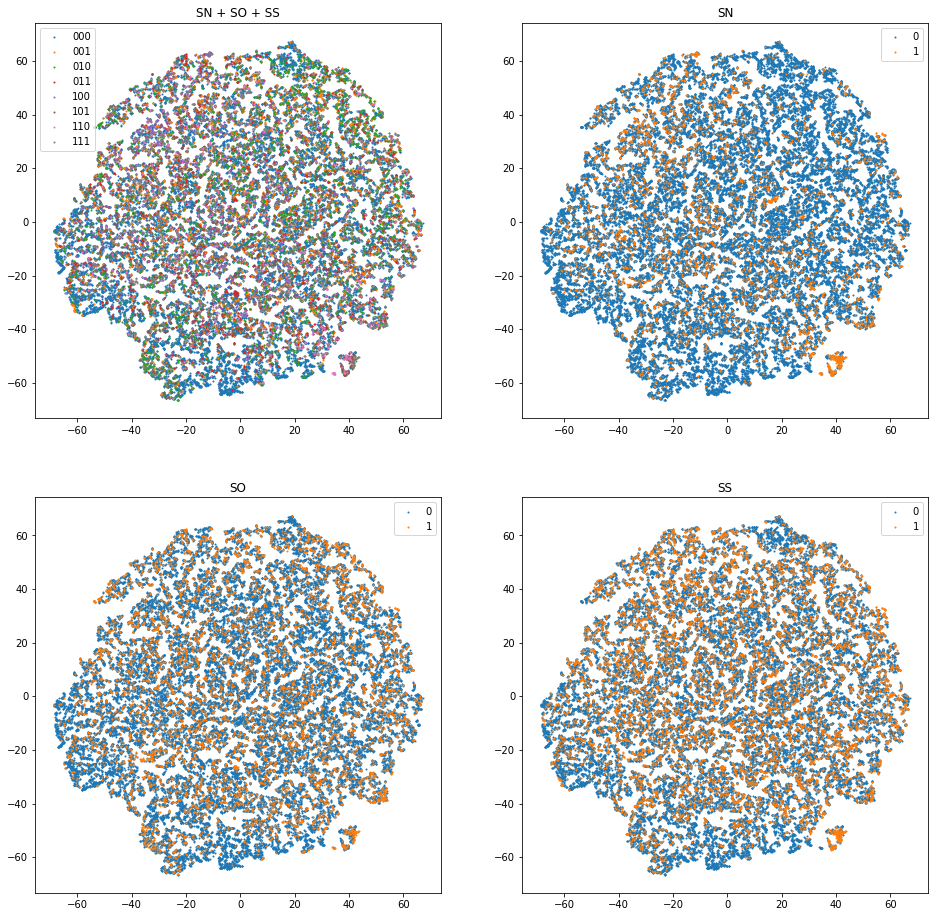

In [165]:

plt.figure(figsize=(16, 16))

plt.subplot(221)
plt.title("SN + SO + SS")

t = result["S_WT_SN"].astype(str) + result["S_WT_SO"].astype(str) + result["S_WT_SS"].astype(str)
for i in sorted(t.unique()):
    tmp = ans[t == i]
    plt.scatter(tmp[:, 0], tmp[:, 1], s=1, label=i)
plt.legend()


for num, i in enumerate(["SN", "SO", "SS"]):
    plt.subplot(222 + num)
    plt.title(i)
    t = result[f"S_WT_{i}"]
    for j in [0, 1]:
        plt.scatter(ans[t == j, 0], ans[t == j, 1], s=1, label=str(j))
    plt.legend()

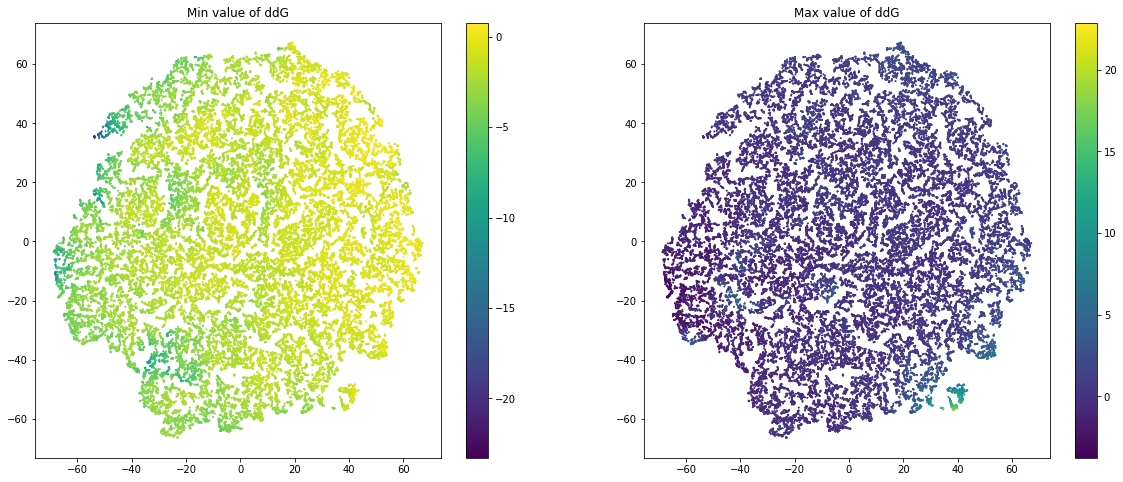

In [138]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.title("Min value of ddG")
#plt.scatter(ans[:, 0], ans[:, 1], s=1, c=ddg.values.std(axis=1))
plt.scatter(ans[:, 0], ans[:, 1], s=1, c=ddg.values.min(axis=1))
plt.colorbar()

plt.subplot(122)
plt.title("Max value of ddG")
plt.scatter(ans[:, 0], ans[:, 1], s=1, c=ddg.values.max(axis=1))
plt.colorbar()

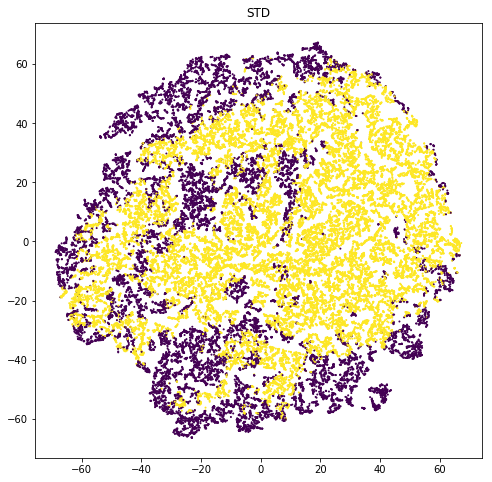

In [131]:
plt.figure(figsize=(8, 8))
plt.title("STD")
#plt.scatter(ans[:, 0], ans[:, 1], s=1, c=ddg.values.std(axis=1))
plt.scatter(ans[:, 0], ans[:, 1], s=1, c=ddg.values.std(axis=1) < 0.9)

#plt.colorbar()

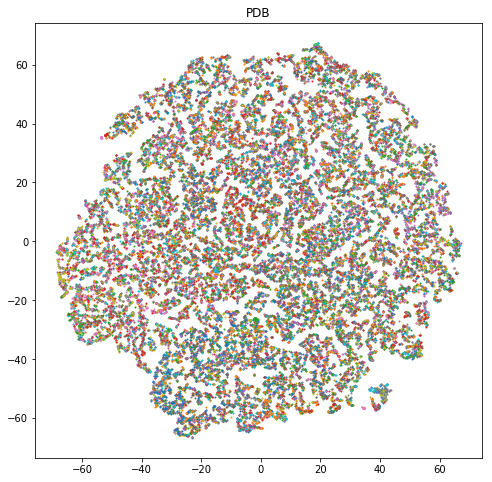

In [213]:
plt.figure(figsize=(8, 8))
plt.title("PDB")
#plt.scatter(ans[:, 0], ans[:, 1], s=1, c=ddg.values.std(axis=1))
for i in result["C_PDB"].unique():
    plt.scatter(ans[result["C_PDB"] == i, 0], ans[result["C_PDB"] == i, 1], s=1, label=i)


In [ ]:
result.

## Feature Distribution

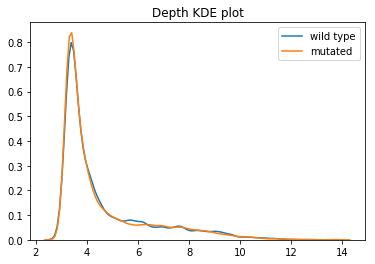

In [67]:
import seaborn as sb
#plt.hist(result["S_WT_DEPTH..angstrom."], bins=100)
plt.title("Depth KDE plot")
sb.kdeplot(result["S_WT_DEPTH..angstrom."], label="wild type")
sb.kdeplot(result["S_MT_DEPTH..angstrom."], label="mutated")


In [79]:
len(result["S_PDB"].unique())

114

In [80]:
114*20*20

45600

## Check program outliers

In [ ]:
ddg.

## BEST R2 to mean value

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
ddg["

## Classfication 0 - 0.5 - 2 - oo

## One Class SVM

In [214]:
from sklearn.svm import OneClassSVM

In [216]:
#outliers
out = Pipeline([("ss", SS()), 
                ("one_class_svm", OneClassSVM())
               ])

outliers = out.fit_predict(ddg)

In [218]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([21657, 21661]))

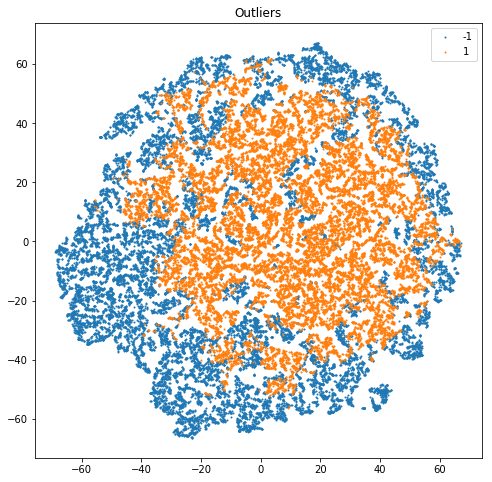

In [219]:
plt.figure(figsize=(8, 8))
plt.title("Outliers")
for i in [-1, 1]:
    tmp = ans[outliers == i]
    plt.scatter(tmp[:, 0], tmp[:, 1], s=1, label=str(i))
plt.legend()

## Clustering

### DBSCAN 

In [139]:
from sklearn.cluster import DBSCAN

In [178]:
cluster = Pipeline([("ss", SS()), 
                    ("clus", DBSCAN(metric="manhattan"))
                   ])

In [202]:
eps = [0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7]
cls = []


for i in eps:
        cls.append(Pipeline([("ss", SS()), 
                    ("clus", DBSCAN(min_samples=40, eps=i, metric="manhattan"))
                   ]))
        
    
for i in cls:
    i.fit(ddg)

In [203]:
for i in cls:
    print(len(np.unique(i.steps[1][1].labels_)))

1
1
1
5
3
2
2


In [204]:
np.unique(cls[3].steps[1][1].labels_, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([40301,  2903,    53,    31,    30]))

In [187]:
lbs = cls.steps[1][1].labels_
lbs.u

In [189]:
np.unique(lbs, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102]),
 array([ 6648, 36067,     5,     6,     6,     7,     8,    36,     7,
            8,     8,     5,     5,     7,     5,     5,     5,     9,
            9,     5,     3,    10,    10,     8,     8,     6,     9,
           13,    12,     6,     5,     6,     7,     5,     6,     5,
           11,     4,     5,     5,     4,     3,     4,     5,     4,
            5,     4,     5,     7,     3,     6,    12,   

## Kmeans

In [220]:
from sklearn.cluster import KMeans

In [222]:
cluster = Pipeline([("ss", SS()), 
                    ("clus", KMeans())
                   ])

In [223]:
cluster.fit(ddg)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clus', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [225]:
np.unique(cluster.steps[1][1].labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([ 3440,  8099,  4093,  3041, 13902,  5404,  4762,   577]))

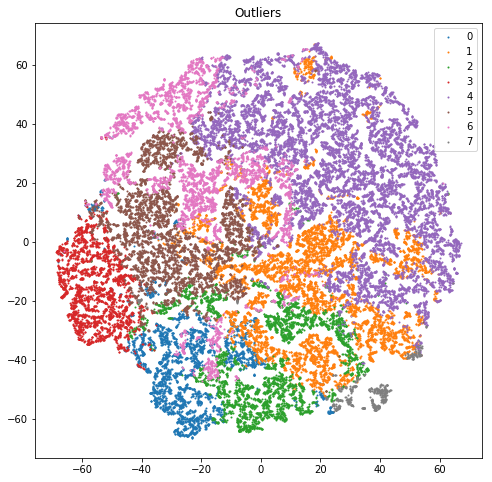

In [226]:
plt.figure(figsize=(8, 8))
plt.title("Outliers")
for i in range(8):
    tmp = ans[cluster.steps[1][1].labels_ == i]
    plt.scatter(tmp[:, 0], tmp[:, 1], s=1, label=str(i))
plt.legend()